# Projeto Smart Prospection

## Passo a passo do projeto

1. Pegar o endereço do vendedor 

> se possível já com latitude e longitude

> caso não tenha lat/lng usar geopy


2. Filtrar estado, cidade e bairro de onde esse vendedor está e filtrar da base de CNPJ;

3. Fazer a conversão dos endereços com o geopy para obter lat/lng;

4. Com as lat/lng calcular a distância dos estabelecimentos a um raio de Xkm;

5. Com os estabelecimentos filtrados, fazer a similaridade (NLP) e filtrar somente aqueles estabelecimentos parecidos com os dos clientes desse vendedor.

> CNAEs iguais

> CNAEs semelhantes (grupos de CNAE)

> Ramoatividade e CNAEs semelhantes


* Verificar se o estabelecimento recomendado já é cliente do vendedor;

* Verificar se o estabelecimento recomendado já é cliente de outro vendedor da mesma empresa;

* Verificar se o estabelecimento recomendado já é cliente de outro vendedor de outra empresa.


## Importando bibliotecas e datasets

In [1]:
import pandas as pd
import numpy as np

#Geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance

#Distância entre pontos
from math import sin, cos, sqrt, atan2, radians
from scipy.spatial.distance import pdist, squareform

from datetime import date
import datetime

In [2]:
# Para aparecer todas as linhas e colunas do dataset

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
#dataset de todos os CNPJ
df_todos = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Farmix/estabelecimentos_empresas_farmix_filial1_todos.csv', dtype=str)

In [ ]:
df_todos.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte
0,28.446.443/0003-91,28446443,FILIAL,20191114,4771701,"Comércio varejista de produtos farmacêuticos, ...",4772500,RUA,SEVERINA CARNEIRO DE ALBUQUERQUE,46,NaN,TABATINGA,54756090,PE,CAMARAGIBE,50000.0,01
1,35.550.872/0001-08,35550872,MATRIZ,20191119,5611203,"Lanchonetes, casas de chá, de sucos e similares","4721102,4723700,4729699",RUA,RUA CARMELITA SOARES MUNIZ DE ARAUJO,225,CONJ 301 ANDAR 3 ...,CASA CAIADA,53130645,PE,OLINDA,26000.0,03
2,35.571.134/0001-47,35571134,MATRIZ,20191120,4712100,"Comércio varejista de mercadorias em geral, co...",NaN,RUA,RUA MARIA CECILIA,S/N,CONJ,CENTRO,55755000,PE,CASINHAS,2000.0,01
3,35.574.088/0001-30,35574088,MATRIZ,20191121,4721104,"Comércio varejista de doces, balas, bombons e ...",NaN,AVENIDA,GOVERNADOR AGAMENON MAGALHAES,15,NaN,SANTO AMARO,50110000,PE,RECIFE,10000.0,01
4,35.615.094/0001-98,35615094,MATRIZ,20191126,4712100,"Comércio varejista de mercadorias em geral, co...","4723700,4721103",RUA,CORONEL ANDRE AVELINO,15,TERREO A,CENTRO,58800530,PB,SOUSA,15000.0,01


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/estabelecimentos_empresas_MG_todos.csv', dtype=str)
df.head(2)

In [ ]:
# dataset dos CNPJ de MG todos
df_mg = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/CNPJ_metadados/estabelecimentos_empresas_MG_todos.csv', dtype=str)
df_mg.head(2)

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01


In [ ]:
# dataset de CNAES

cnaes = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/categorias_cnaes_atuais.csv', dtype=str)
cnaes.head(2)

,cnae,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
0,0111301,Cultivo de arroz,A,01,01.1,01.11-3,0111-3/01,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...","AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",Produção de lavouras temporárias,Cultivo de cereais,Cultivo de arroz
1,0111302,Cultivo de milho,A,01,01.1,01.11-3,0111-3/02,"AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PES...","AGRICULTURA, PECUÁRIA E SERVIÇOS RELACIONADOS",Produção de lavouras temporárias,Cultivo de cereais,Cultivo de milho


In [ ]:
cnaes[cnaes['cnae'] == 9001906]

,cnae,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
1294,9001906,Atividades de sonorização e de iluminação,R,90,90.0,90.01-9,9001-9/06,"ARTES, CULTURA, ESPORTE E RECREAÇÃO","ATIVIDADES ARTÍSTICAS, CRIATIVAS E DE ESPETÁCULOS","Atividades artísticas, criativas e de espetáculos","Artes cênicas, espetáculos e atividades comple...",Atividades de sonorização e de iluminação


In [ ]:
clientes_gama = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/DISTRIBUIDORA GAMA/IONV_CLIENTES.csv', sep=';')
clientes_gama.head()

,codcli,codcliprinc,razaosocial,fantasia,cnpj,consumidorfinal,codcob,codplpag,dtultcomp,inscrestadual,inscrmunicipal,tipofj,bloqueio,dtbloqueio,codpraca,codcidade,codramoativ,codrede,rg,orgaorg,site,email,emailnfe,classevenda,recemcadastrado,bloqueiodefinitivo,bloqueiorede,codgrupocli,dtpricompra,forcatipofj,tipo_cliente,emailcob
0,6,6,FARMACIA FITAR VIDA LTDA,FARMACIA FITAR VIDA - MATRIZ,25.820.960/0001-29,N,BBCR,4,2022-11-29 00:00:00,2985969010004,NaN,J,N,NaN,1,8144,1,NaN,NaN,NaN,NaN,nfe0001.29@gmail.com,nfe0001.29@gmail.com,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
1,8,8,DROGARIA ADPASSOS LTDA - ME,FARMACIA DROGARIA SAO GERALDO,19.209.428/0001-77,N,BBCR,11,2019-02-21 00:00:00,0900759010009,NaN,J,Y,2019-12-10 00:00:00,1,7903,1,NaN,NaN,NaN,NaN,fsaogeraldo@yahoo.com.br,fsaogeraldo@yahoo.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
2,9,9,DROGARIA NEVES & NEVES LTDA - ME,DROGARIA VITAL SAUDE,25.431.933/0001-64,N,BBCR,11,2021-10-15 00:00:00,081587015.00-14,NaN,J,Y,2022-03-15 00:00:00,1,7892,1,186.0,NaN,NaN,NAO MANDAR ARQUIVO XML.,dnsamatriz@conqnet.com.br,dnsamatriz@conqnet.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
3,14,14,PREF. MUN. DE PIEDADE DOS GERAIS,NaN,18.363.960/0001-81,Y,BBCR,187,NaN,ISENTO,NaN,J,Y,2019-12-10 00:00:00,28,8395,1,NaN,NaN,NaN,NaN,pmgerais@zipmail.com.br,pmgerais@zipmail.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
4,21,21,LEO FARMA LTDA,DROGARIA PRECO BAIXO LTDA,17.818.220/0001-20,N,BBCR,454,2011-10-05 00:00:00,0623925420028,NaN,J,Y,2019-12-10 00:00:00,1,7872,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN


In [ ]:
clientes_endereco = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/DISTRIBUIDORA GAMA/IONV_CLIENTES_ENDERECOS.csv', sep=';')
clientes_endereco.head()

,codcli,tipoendereco,codendereco,endereco,complemento,bairro,cidade,estado,cep,telefone,fax,pontoreferencia,codbairro,codpraca,codcidade,codpais,numero,celular,numregiaofrete,descricao,excluido,principal
0,6,CB,0,"RUA OTACILIO NEGRAO DE LIMA, 17",1,CENTRO,IBIRITE,MG,32400-206,(31) 9978-392,NaN,NaN,NaN,1,3129806,1058.0,17,NaN,NaN,NaN,NaN,NaN
1,6,CM,0,"RUA OTACILIO NEGRAO DE LIMA, 17",1,CENTRO,IBIRITE,MG,32400-206,(31) 9978-392,(31)3303-0361,NaN,NaN,1,3129806,1058.0,17,NaN,NaN,NaN,NaN,NaN
2,6,ET,0,"RUA OTACILIO NEGRAO DE LIMA, 17",1,CENTRO,IBIRITE,MG,32400-206,(31) 9978-3925,NaN,NaN,NaN,1,3129806,1058.0,17,(31)99783-9253,NaN,NaN,NaN,NaN
3,8,CB,0,RUA GOVERNADOR VALADARES,1,CENTRO,BRUMADINHO,MG,35460-000,(31)3571-1421,NaN,NaN,NaN,1,3109006,1058.0,45,NaN,NaN,NaN,NaN,NaN
4,8,CM,0,RUA GOVERNADOR VALADARES,1,CENTRO,BRUMADINHO,MG,35460-000,(31)3571-1421,(31)3571-1597,NaN,NaN,1,3109006,1058.0,45,NaN,NaN,NaN,NaN,NaN


In [ ]:
clientes_endereco.estado.value_counts()

MG    873
Name: estado, dtype: int64

## Pegando um bairro específico

Nesse caso será pegue o bairro JARDIM DE ALA (JUSTINOPOLIS)



In [ ]:
jardim = df[df['bairro'] == 'JARDIM DE ALA (JUSTINOPOLIS)']
jardim.head(2)

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico
6,37.392.382/0001-56,MATRIZ,NaN,NaN,20200612,Serviços de entrega rápida,5320202,NaN,AVENIDA,OURO VERDE,300,APT 202,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,88618906.0,NaN,NaN,NaN
13711,40.035.426/0001-03,MATRIZ,GARAGE'S FOOD,NaN,20201207,Restaurantes e similares,5611201,5611203,RUA,PIRATININGA,11,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943630,MG,RIBEIRAO DAS NEVES,31.0,99412433.0,NaN,NaN,GARAGESFOOD@GMAIL.COM


In [ ]:
jardim.shape

(201, 21)

## Geocodificando endereços (geopy)

In [ ]:
jardim['endereco'] = jardim['tipo_logradouro'] + ' ' + jardim['logradouro'] + ', ' + jardim['numero']+ ', ' + jardim['municipio'] + ', ' + jardim['uf'] + ', BRASIL'
jardim['endereco'] = jardim['endereco'].str.lower()
jardim.head(2)

<ipython-input-12-90f9bd68cc4c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jardim['endereco'] = jardim['tipo_logradouro'] + ' ' + jardim['logradouro'] + ', ' + jardim['numero']+ ', ' + jardim['municipio'] + ', ' + jardim['uf'] + ', BRASIL'
<ipython-input-12-90f9bd68cc4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jardim['endereco'] = jardim['endereco'].str.lower()


,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico,endereco
6,37.392.382/0001-56,MATRIZ,NaN,NaN,20200612,Serviços de entrega rápida,5320202,NaN,AVENIDA,OURO VERDE,300,APT 202,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,88618906.0,NaN,NaN,NaN,"avenida ouro verde, 300, ribeirao das neves, m..."
13711,40.035.426/0001-03,MATRIZ,GARAGE'S FOOD,NaN,20201207,Restaurantes e similares,5611201,5611203,RUA,PIRATININGA,11,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943630,MG,RIBEIRAO DAS NEVES,31.0,99412433.0,NaN,NaN,GARAGESFOOD@GMAIL.COM,"rua piratininga, 11, ribeirao das neves, mg, b..."


In [ ]:
locator = Nominatim(user_agent="myGeocoder")

In [ ]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [ ]:
jardim['endereco_geolocalizado'] = jardim['endereco'].apply(geocode)

<ipython-input-14-b38bfd6bc846>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jardim['endereco_geolocalizado'] = jardim['endereco'].apply(geocode)


In [ ]:
jardim.head(2)

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico,endereco,endereco_geolocalizado
6,37.392.382/0001-56,MATRIZ,NaN,NaN,20200612,Serviços de entrega rápida,5320202,NaN,AVENIDA,OURO VERDE,300,APT 202,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,88618906.0,NaN,NaN,NaN,"avenida ouro verde, 300, ribeirao das neves, m...","(Avenida Ouro Verde, São Miguel Arcanjo, Justi..."
13711,40.035.426/0001-03,MATRIZ,GARAGE'S FOOD,NaN,20201207,Restaurantes e similares,5611201,5611203,RUA,PIRATININGA,11,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943630,MG,RIBEIRAO DAS NEVES,31.0,99412433.0,NaN,NaN,GARAGESFOOD@GMAIL.COM,"rua piratininga, 11, ribeirao das neves, mg, b...","(Rua Piratininga, Jardim de Alá, Justinópolis,..."


In [ ]:
jardim['endereco_geolocalizado'].isna().sum()

6

In [ ]:
jardim[jardim['endereco_geolocalizado'].isna()]

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico,endereco,endereco_geolocalizado,latitude,longitude,geocoder
51,47.540.215/0001-69,MATRIZ,NaN,NaN,20220812,Serviços de entrega rápida,5320202,4330404,RUA,MONTE REY,27,CASA,JARDIM DE ALA (JUSTINOPOLIS),33943260,MG,RIBEIRAO DAS NEVES,31.0,97009194.0,NaN,NaN,GNIHC123@GMAIL.COM,"rua monte rey, 27, ribeirao das neves, mg, brasil",NaN,NaN,NaN,NaN
93,47.888.356/0001-77,MATRIZ,EMPI MECATRONIC,NaN,20220909,Serviços de manutenção e reparação mecânica de...,4520001,NaN,RUA,DOS CRISTAIS,260A,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943320,MG,RIBEIRAO DAS NEVES,31.0,84507823.0,NaN,NaN,EMPIMECATRONIC@GMAIL.COM,"rua dos cristais, 260a, ribeirao das neves, mg...",NaN,NaN,NaN,NaN
94,48.858.390/0001-61,MATRIZ,GR DESENVOLVIMENTO DE SISTEMA,NaN,20221212,Desenvolvimento de programas de computador sob...,6201501,"6201502,6202300",AVENIDA,MONTE CASTELO,608,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943252,MG,RIBEIRAO DAS NEVES,31.0,89354574.0,NaN,NaN,GLEISON_RODRIGUES@YAHOO.COM.BR,"avenida monte castelo, 608, ribeirao das neves...",NaN,NaN,NaN,NaN
109,46.761.712/0001-24,MATRIZ,NaN,NaN,20220613,"Transporte rodoviário de carga, exceto produto...",4930202,"4930204,4930201",AVENIDA,MONTE CASTELO,568,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943252,MG,RIBEIRAO DAS NEVES,31.0,88781408.0,NaN,NaN,NATHEUSMF889@GMAIL.COM,"avenida monte castelo, 568, ribeirao das neves...",NaN,NaN,NaN,NaN
183,37.483.632/0001-63,MATRIZ,LATICINIOS FERREIRA,NaN,20200622,Serviços ambulantes de alimentação,5612100,4721103,RUA,MONTE REY,106,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943260,MG,RIBEIRAO DAS NEVES,31.0,86460529.0,NaN,NaN,NaN,"rua monte rey, 106, ribeirao das neves, mg, br...",NaN,NaN,NaN,NaN
188,43.212.236/0001-02,MATRIZ,FERREIRA CUIDADOS,NaN,20210820,Atividades de fornecimento de infra-estrutura ...,8712300,NaN,RUA,MONTE REY,75,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943260,MG,RIBEIRAO DAS NEVES,31.0,36386037.0,NaN,NaN,FERREIRA.SALETEDIAS@GMAIL.COM,"rua monte rey, 75, ribeirao das neves, mg, brasil",NaN,NaN,NaN,NaN


In [ ]:
jardim['latitude'] = jardim['endereco_geolocalizado'].apply(lambda loc: loc.latitude if loc else None)
jardim['longitude'] = jardim['endereco_geolocalizado'].apply(lambda loc: loc.longitude if loc else None)
jardim['geocoder'] = jardim['endereco_geolocalizado'].apply(lambda loc: tuple(loc.point) if loc else None)
jardim.head()

<ipython-input-17-b74fbb05c3aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jardim['latitude'] = jardim['endereco_geolocalizado'].apply(lambda loc: loc.latitude if loc else None)
<ipython-input-17-b74fbb05c3aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jardim['longitude'] = jardim['endereco_geolocalizado'].apply(lambda loc: loc.longitude if loc else None)
<ipython-input-17-b74fbb05c3aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico,endereco,endereco_geolocalizado,latitude,longitude,geocoder
6,37.392.382/0001-56,MATRIZ,NaN,NaN,20200612,Serviços de entrega rápida,5320202,NaN,AVENIDA,OURO VERDE,300,APT 202,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,88618906.0,NaN,NaN,NaN,"avenida ouro verde, 300, ribeirao das neves, m...","(Avenida Ouro Verde, São Miguel Arcanjo, Justi...",-19.799541,-44.017115,"(-19.799541, -44.0171151, 0.0)"
13711,40.035.426/0001-03,MATRIZ,GARAGE'S FOOD,NaN,20201207,Restaurantes e similares,5611201,5611203,RUA,PIRATININGA,11,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943630,MG,RIBEIRAO DAS NEVES,31.0,99412433.0,NaN,NaN,GARAGESFOOD@GMAIL.COM,"rua piratininga, 11, ribeirao das neves, mg, b...","(Rua Piratininga, Jardim de Alá, Justinópolis,...",-19.806701,-44.021607,"(-19.8067008, -44.0216066, 0.0)"
22066,41.106.369/0001-60,MATRIZ,PIZZARIA DA LINDAURA,NaN,20210305,Serviços de alimentação para eventos e recepçõ...,5620102,NaN,RUA,DO CAMPO,11,CONJ 2,JARDIM DE ALA (JUSTINOPOLIS),33943233,MG,RIBEIRAO DAS NEVES,31.0,85800232.0,NaN,NaN,LINDADARK9@GMAIL.COM,"rua do campo, 11, ribeirao das neves, mg, brasil","(Rua do Campo, Eliane, Justinópolis, Ribeirão ...",-19.814770,-44.020641,"(-19.8147701, -44.0206408, 0.0)"
36951,42.665.147/0001-40,MATRIZ,EBENEZER A&V PINTURAS,NaN,20210711,Serviços de pintura de edifícios em geral,4330404,4741500,RUA,CURVELO,315,CASA 2,JARDIM DE ALA (JUSTINOPOLIS),33943770,MG,RIBEIRAO DAS NEVES,31.0,87538949.0,NaN,NaN,AMAURIAURELINOAURELINO@GMAIL.COM,"rua curvelo, 315, ribeirao das neves, mg, brasil","(Rua Curvelo, Vila Papine, Justinópolis, Ribei...",-19.803343,-44.020771,"(-19.8033429, -44.0207707, 0.0)"
50785,44.080.036/0001-06,MATRIZ,ACAI DRINKS,NaN,20211030,Comércio varejista de produtos alimentícios em...,4729699,NaN,AVENIDA,OURO VERDE,238,CASA,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,75099824.0,NaN,NaN,FA8361272@GMAIL.COM,"avenida ouro verde, 238, ribeirao das neves, m...","(Avenida Ouro Verde, Vila Papine, Justinópolis...",-19.799550,-44.017191,"(-19.79955, -44.0171908, 0.0)"


In [ ]:
# jardim.to_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/CNPJ_metadados/bairro_jardim_geolocalizado(atualizado).csv', index=False)

## Distância entre dois pontos geolocalizados

In [ ]:
jardim = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/CNPJ_metadados/bairro_jardim_geolocalizado(atualizado).csv')
jardim.head(2)

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico,endereco,endereco_geolocalizado,latitude,longitude,geocoder
0,37.392.382/0001-56,MATRIZ,NaN,NaN,20200612,Serviços de entrega rápida,5320202,NaN,AVENIDA,OURO VERDE,300,APT 202,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,88618906.0,NaN,NaN,NaN,"avenida ouro verde, 300, ribeirao das neves, m...","Avenida Ouro Verde, São Miguel Arcanjo, Justin...",-19.799541,-44.017115,"(-19.799541, -44.0171151, 0.0)"
1,40.035.426/0001-03,MATRIZ,GARAGE'S FOOD,NaN,20201207,Restaurantes e similares,5611201,5611203,RUA,PIRATININGA,11,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943630,MG,RIBEIRAO DAS NEVES,31.0,99412433.0,NaN,NaN,GARAGESFOOD@GMAIL.COM,"rua piratininga, 11, ribeirao das neves, mg, b...","Rua Piratininga, Jardim de Alá, Justinópolis, ...",-19.806701,-44.021607,"(-19.8067008, -44.0216066, 0.0)"


Lembrar que alguns estabelecimentos estão sendo excluídos porque o Geopy não identificou a coordenada (resolver depois esse caso usando o geocode do google ou outro).

In [ ]:
jardim.dropna(subset=['geocoder'], inplace=True)
jardim.isnull().sum()

cnpj                             0
identificador_matriz_filial      0
nome_fantasia                   29
pais                           195
data_inicio_atividade            0
cnae                             0
cnae_fiscal_principal            0
cnae_fiscal_secundaria          97
tipo_logradouro                  0
logradouro                       0
numero                           0
complemento                    122
bairro                           0
cep                              0
uf                               0
municipio                        0
ddd1                             0
telefone1                        0
ddd2                           190
telefone2                      190
correio_eletronico              18
endereco                         0
endereco_geolocalizado           0
latitude                         0
longitude                        0
geocoder                         0
dtype: int64

In [ ]:
def dist(coord1, coord2):
    """Função para calcular a distância entre dois pontos x, y"""
    result = pd.DataFrame()

    lat1 = radians(coord1[0])
    lon1 = radians(coord1[1])
    lat2 = radians(coord2[0])
    lon2 = radians(coord2[1])

    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return round(distance, 4)

Pro nosso exemplo da POC a referência será da coordenada 1, pois essa será o ponto em que o vendedor está, por exemplo. Portanto, será a primeira linha do dataframe.

In [ ]:
jardim.geocoder.loc[:0][0]

'(-19.799541, -44.0171151, 0.0)'

In [ ]:
coord1 = eval(jardim.geocoder.loc[:0][0])
coord1

(-19.799541, -44.0171151, 0.0)

In [ ]:
jardim['distancia'] = jardim.geocoder.apply(lambda x: dist(coord1,eval(x)))
jardim.head()

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico,endereco,endereco_geolocalizado,latitude,longitude,geocoder,distancia
0,37.392.382/0001-56,MATRIZ,NaN,NaN,20200612,Serviços de entrega rápida,5320202,NaN,AVENIDA,OURO VERDE,300,APT 202,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,88618906.0,NaN,NaN,NaN,"avenida ouro verde, 300, ribeirao das neves, m...","Avenida Ouro Verde, São Miguel Arcanjo, Justin...",-19.799541,-44.017115,"(-19.799541, -44.0171151, 0.0)",0.0000
1,40.035.426/0001-03,MATRIZ,GARAGE'S FOOD,NaN,20201207,Restaurantes e similares,5611201,5611203,RUA,PIRATININGA,11,NaN,JARDIM DE ALA (JUSTINOPOLIS),33943630,MG,RIBEIRAO DAS NEVES,31.0,99412433.0,NaN,NaN,GARAGESFOOD@GMAIL.COM,"rua piratininga, 11, ribeirao das neves, mg, b...","Rua Piratininga, Jardim de Alá, Justinópolis, ...",-19.806701,-44.021607,"(-19.8067008, -44.0216066, 0.0)",0.9248
2,41.106.369/0001-60,MATRIZ,PIZZARIA DA LINDAURA,NaN,20210305,Serviços de alimentação para eventos e recepçõ...,5620102,NaN,RUA,DO CAMPO,11,CONJ 2,JARDIM DE ALA (JUSTINOPOLIS),33943233,MG,RIBEIRAO DAS NEVES,31.0,85800232.0,NaN,NaN,LINDADARK9@GMAIL.COM,"rua do campo, 11, ribeirao das neves, mg, brasil","Rua do Campo, Eliane, Justinópolis, Ribeirão d...",-19.814770,-44.020641,"(-19.8147701, -44.0206408, 0.0)",1.7336
3,42.665.147/0001-40,MATRIZ,EBENEZER A&V PINTURAS,NaN,20210711,Serviços de pintura de edifícios em geral,4330404,4741500,RUA,CURVELO,315,CASA 2,JARDIM DE ALA (JUSTINOPOLIS),33943770,MG,RIBEIRAO DAS NEVES,31.0,87538949.0,NaN,NaN,AMAURIAURELINOAURELINO@GMAIL.COM,"rua curvelo, 315, ribeirao das neves, mg, brasil","Rua Curvelo, Vila Papine, Justinópolis, Ribeir...",-19.803343,-44.020771,"(-19.8033429, -44.0207707, 0.0)",0.5703
4,44.080.036/0001-06,MATRIZ,ACAI DRINKS,NaN,20211030,Comércio varejista de produtos alimentícios em...,4729699,NaN,AVENIDA,OURO VERDE,238,CASA,JARDIM DE ALA (JUSTINOPOLIS),33943700,MG,RIBEIRAO DAS NEVES,31.0,75099824.0,NaN,NaN,FA8361272@GMAIL.COM,"avenida ouro verde, 238, ribeirao das neves, m...","Avenida Ouro Verde, Vila Papine, Justinópolis,...",-19.799550,-44.017191,"(-19.79955, -44.0171908, 0.0)",0.0080


In [ ]:
raio = 1
raio1 = jardim[jardim['distancia'] <= raio]
raio1.shape

(152, 27)

## Dados dos clientes do vendedor

Juntar os CNPJs da base de dados dos clientes desse vendedor e pegar os CNAEs da base de CNPJ do Brasil.

In [ ]:
clientes_gama.head()

,codcli,codcliprinc,razaosocial,fantasia,cnpj,consumidorfinal,codcob,codplpag,dtultcomp,inscrestadual,inscrmunicipal,tipofj,bloqueio,dtbloqueio,codpraca,codcidade,codramoativ,codrede,rg,orgaorg,site,email,emailnfe,classevenda,recemcadastrado,bloqueiodefinitivo,bloqueiorede,codgrupocli,dtpricompra,forcatipofj,tipo_cliente,emailcob
0,6,6,FARMACIA FITAR VIDA LTDA,FARMACIA FITAR VIDA - MATRIZ,25.820.960/0001-29,N,BBCR,4,2022-11-29 00:00:00,2985969010004,NaN,J,N,NaN,1,8144,1,NaN,NaN,NaN,NaN,nfe0001.29@gmail.com,nfe0001.29@gmail.com,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
1,8,8,DROGARIA ADPASSOS LTDA - ME,FARMACIA DROGARIA SAO GERALDO,19.209.428/0001-77,N,BBCR,11,2019-02-21 00:00:00,0900759010009,NaN,J,Y,2019-12-10 00:00:00,1,7903,1,NaN,NaN,NaN,NaN,fsaogeraldo@yahoo.com.br,fsaogeraldo@yahoo.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
2,9,9,DROGARIA NEVES & NEVES LTDA - ME,DROGARIA VITAL SAUDE,25.431.933/0001-64,N,BBCR,11,2021-10-15 00:00:00,081587015.00-14,NaN,J,Y,2022-03-15 00:00:00,1,7892,1,186.0,NaN,NaN,NAO MANDAR ARQUIVO XML.,dnsamatriz@conqnet.com.br,dnsamatriz@conqnet.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
3,14,14,PREF. MUN. DE PIEDADE DOS GERAIS,NaN,18.363.960/0001-81,Y,BBCR,187,NaN,ISENTO,NaN,J,Y,2019-12-10 00:00:00,28,8395,1,NaN,NaN,NaN,NaN,pmgerais@zipmail.com.br,pmgerais@zipmail.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN
4,21,21,LEO FARMA LTDA,DROGARIA PRECO BAIXO LTDA,17.818.220/0001-20,N,BBCR,454,2011-10-05 00:00:00,0623925420028,NaN,J,Y,2019-12-10 00:00:00,1,7872,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN


In [ ]:
clientes_gama.shape

(291, 32)

In [ ]:
df_mg.head()

,cnpj,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico
0,37.391.365/0001-02,MATRIZ,GENERAL ASSISTANT,NaN,20200612,Atividades de sonorização e de iluminação,9001906,2330399,11A RUA,GUARANESIA,463,CASA,PARQUE DOS MUNICIPIOS 1,37800000,MG,GUAXUPE,35.0,92665263.0,NaN,NaN,DOLIVANSILVA@GMAIL.COM
1,37.391.461/0001-42,MATRIZ,REBOQUE RODRIGUES,NaN,20200612,"Transporte rodoviário de carga, exceto produto...",4930201,NaN,RUA,CIDRA,18,CASA;CASA;CASA;CASA,LIMOEIRO,35162854,MG,IPATINGA,31.0,86030816.0,NaN,NaN,VVIDROFLEX@GMAIL.COM
2,37.391.603/0001-71,MATRIZ,ELIMACLEY,NaN,20200612,Comércio varejista de bebidas,4723700,NaN,RUA,DAVID RABELO,1175,NaN,ALIPIO DE MELO,30820575,MG,BELO HORIZONTE,31.0,85797489.0,NaN,NaN,ELIMACLEY@GMAIL.COM
3,37.391.664/0001-39,MATRIZ,NaN,NaN,20200612,Fabricação de outros artigos de carpintaria pa...,1622699,NaN,RUA,RIO GRANDE DO SUL,510,SALA C,VILA NOVA,39860000,MG,NANUQUE,21.0,69300545.0,NaN,NaN,NaN
4,37.391.831/0001-41,MATRIZ,CANTINA DE CONVENIENCIA,NaN,20200612,Cantinas - serviços de alimentação privativos,5620103,"5611204,5611203",RUA,OLEGARIO MACIEL,778,NaN,SAO JOSE,35590000,MG,LAGOA DA PRATA,37.0,99470940.0,NaN,NaN,PAULAO.PAULAO2020@BOL.COM.BR


In [ ]:
cli_gama_cnae = pd.merge(clientes_gama, df_mg, how = 'left', on = 'cnpj')
cli_gama_cnae.head()

,codcli,codcliprinc,razaosocial,fantasia,cnpj,consumidorfinal,codcob,codplpag,dtultcomp,inscrestadual,inscrmunicipal,tipofj,bloqueio,dtbloqueio,codpraca,codcidade,codramoativ,codrede,rg,orgaorg,site,email,emailnfe,classevenda,recemcadastrado,bloqueiodefinitivo,bloqueiorede,codgrupocli,dtpricompra,forcatipofj,tipo_cliente,emailcob,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico
0,6,6,FARMACIA FITAR VIDA LTDA,FARMACIA FITAR VIDA - MATRIZ,25.820.960/0001-29,N,BBCR,4,2022-11-29 00:00:00,2985969010004,NaN,J,N,NaN,1,8144,1,NaN,NaN,NaN,NaN,nfe0001.29@gmail.com,nfe0001.29@gmail.com,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,FARMACIAS FITARVIDA,NaN,19890522.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,"4713002,4721104,4729602,4729699,4763601,477250...",RUA,OTACILIO NEGRAO DE LIMA,17,NaN,CENTRO,32400206.0,MG,IBIRITE,31.0,32796992,NaN,NaN,REGISTROFONSECA@CONTABILFONSECA.COM.BR
1,8,8,DROGARIA ADPASSOS LTDA - ME,FARMACIA DROGARIA SAO GERALDO,19.209.428/0001-77,N,BBCR,11,2019-02-21 00:00:00,0900759010009,NaN,J,Y,2019-12-10 00:00:00,1,7903,1,NaN,NaN,NaN,NaN,fsaogeraldo@yahoo.com.br,fsaogeraldo@yahoo.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,NaN,NaN,19770202.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,"4729602,4729699,4772500,4773300,4789005",RUA,GOVERNADOR VALADARES,45,NaN,CENTRO,35460000.0,MG,BRUMADINHO,31.0,35711597,NaN,NaN,FSAOGERALDO@YAHOO.COM.BR
2,9,9,DROGARIA NEVES & NEVES LTDA - ME,DROGARIA VITAL SAUDE,25.431.933/0001-64,N,BBCR,11,2021-10-15 00:00:00,081587015.00-14,NaN,J,Y,2022-03-15 00:00:00,1,7892,1,186.0,NaN,NaN,NAO MANDAR ARQUIVO XML.,dnsamatriz@conqnet.com.br,dnsamatriz@conqnet.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,DROGARIA VITAL SAUDE,NaN,19881014.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,"4729699,4789001,4772500",AVENIDA,GOVERNADOR BENEDITO VALADARES,106,NaN,CENTRO,35480000.0,MG,BONFIM,31.0,35761881.0,NaN,NaN,CSB.CONSULTORIA@TERRA.COM.BR
3,14,14,PREF. MUN. DE PIEDADE DOS GERAIS,NaN,18.363.960/0001-81,Y,BBCR,187,NaN,ISENTO,NaN,J,Y,2019-12-10 00:00:00,28,8395,1,NaN,NaN,NaN,NaN,pmgerais@zipmail.com.br,pmgerais@zipmail.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,MUNICIPIO DE PIEDADE DOS GERAIS,NaN,19741231.0,Administração pública em geral,8411600.0,NaN,RUA,RUA NOSSO SENHOR DO BONFIM,693,NaN,CENTRO,35476000.0,MG,PIEDADE DOS GERAIS,31.0,35084060,NaN,NaN,CONTATO@PIEDADEDOSGERAIS.MG.GOV.BR
4,21,21,LEO FARMA LTDA,DROGARIA PRECO BAIXO LTDA,17.818.220/0001-20,N,BBCR,454,2011-10-05 00:00:00,0623925420028,NaN,J,Y,2019-12-10 00:00:00,1,7872,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,NaN,NaN,19830406.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,NaN,RUA,ARISTOLINO BASILIO DE OLIVEIRA,115,LOJA 03,REGINA,30692190.0,MG,BELO HORIZONTE,NaN,NaN,NaN,NaN,NaN


In [ ]:
cli_gama_cnae.shape

(291, 52)

In [ ]:
cli_gama_cnae.isnull().sum()

codcli                           0
codcliprinc                      0
razaosocial                      0
fantasia                        39
cnpj                             0
consumidorfinal                  0
codcob                           0
codplpag                         0
dtultcomp                       38
inscrestadual                    0
inscrmunicipal                 291
tipofj                           0
bloqueio                         0
dtbloqueio                     113
codpraca                         0
codcidade                        0
codramoativ                      0
codrede                        237
rg                             287
orgaorg                        290
site                           287
email                           31
emailnfe                        28
classevenda                    291
recemcadastrado                  0
bloqueiodefinitivo               0
bloqueiorede                     0
codgrupocli                    291
dtpricompra         

In [ ]:
cli_cnae_nulo = cli_gama_cnae[cli_gama_cnae.cnae.isnull()]

In [ ]:
cli_cnae_nulo

,codcli,codcliprinc,razaosocial,fantasia,cnpj,consumidorfinal,codcob,codplpag,dtultcomp,inscrestadual,inscrmunicipal,tipofj,bloqueio,dtbloqueio,codpraca,codcidade,codramoativ,codrede,rg,orgaorg,site,email,emailnfe,classevenda,recemcadastrado,bloqueiodefinitivo,bloqueiorede,codgrupocli,dtpricompra,forcatipofj,tipo_cliente,emailcob,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico
72,5950,5950,KILDER ALVES ARANTES,KILDER ALVES ARANTES,030.370.916-22,Y,BBCR,187,NaN,ISENTO,NaN,F,Y,2019-12-10 00:00:00,28,7872,1,NaN,NaN,NaN,NaN,kilder.arantes@ig.com.br,kilder.arantes@ig.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,8756,8756,WALDIMIRO JACOB DA SILVA,WALDIMIRO JACOB DA SILVA,227.949.136-20,Y,C,187,2017-03-07 00:00:00,ISENTO,NaN,F,Y,2019-12-10 00:00:00,28,7872,103,NaN,22794913620,NaN,NaN,BETODELI@YAHOO.COM.BR,BETODELI@YAHOO.COM.BR,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,11401,11401,ANTONIO GOMES XAVIER,BAIANO,391.648.456-72,Y,C,999,2015-11-17 00:00:00,ISENTO,NaN,F,Y,2019-12-10 00:00:00,28,7872,1,NaN,MG-5.455.301,NaN,NaN,NaN,NaN,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,12147,12147,CONCEICAO APARECIDA SILVA CAMPOS,CONCEICAO APARECIDA SILVA CAMPOS,024.380.516-04,Y,BBCR,11,2011-05-12 00:00:00,ISENTO,NaN,F,Y,2019-12-10 00:00:00,28,8395,1,NaN,000,NaN,NaN,teste@teste.com.br,teste@teste.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,12527,12527,PEDRO HENRIQUE MARQUES PARREIRA DUARTE,DRIVE- IN MILLENIUN,111.489.756-67,Y,BBCR,11,2022-10-07 00:00:00,ISENTO,NaN,F,Y,2022-10-07 00:00:00,28,7872,104,NaN,11148975667,NaN,NaN,pedroparreira9@yahoo.com.br,pedroparreira9@yahoo.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,28304,28304,JOAO EUSTAQUIO TORQUATO,JOAO EUSTAQUIO TORQUATO,137.266.256-15,Y,BBCR,11,2015-11-19 00:00:00,ISENTO,NaN,F,Y,2019-12-10 00:00:00,28,7872,1,NaN,NaN,NaN,NaN,tor4ecologico@ig.com.br,tor4ecologico@ig.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# cli_cnae_nulo.to_csv('cnae_nulo_cnpj_mg.csv', index=False)

In [ ]:
cli_gama_cnae.dropna(subset=['cnae'], inplace=True)
cli_gama_cnae.isnull().sum()

codcli                           0
codcliprinc                      0
razaosocial                      0
fantasia                        39
cnpj                             0
consumidorfinal                  0
codcob                           0
codplpag                         0
dtultcomp                       37
inscrestadual                    0
inscrmunicipal                 285
tipofj                           0
bloqueio                         0
dtbloqueio                     113
codpraca                         0
codcidade                        0
codramoativ                      0
codrede                        231
rg                             285
orgaorg                        284
site                           281
email                           30
emailnfe                        27
classevenda                    285
recemcadastrado                  0
bloqueiodefinitivo               0
bloqueiorede                     0
codgrupocli                    285
dtpricompra         

In [ ]:
cli_gama_cnae.shape

(285, 52)

In [ ]:
# cli_gama_cnae.to_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/CNPJ_metadados/cli_gama_cnae.csv')

In [ ]:
cli_gama_cnae = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Smart_Locator/datasets/CNPJ_metadados/cli_gama_cnae.csv')
cli_gama_cnae.head()

,Unnamed: 0,codcli,codcliprinc,razaosocial,fantasia,cnpj,consumidorfinal,codcob,codplpag,dtultcomp,inscrestadual,inscrmunicipal,tipofj,bloqueio,dtbloqueio,codpraca,codcidade,codramoativ,codrede,rg,orgaorg,site,email,emailnfe,classevenda,recemcadastrado,bloqueiodefinitivo,bloqueiorede,codgrupocli,dtpricompra,forcatipofj,tipo_cliente,emailcob,identificador_matriz_filial,nome_fantasia,pais,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,ddd1,telefone1,ddd2,telefone2,correio_eletronico
0,0,6,6,FARMACIA FITAR VIDA LTDA,FARMACIA FITAR VIDA - MATRIZ,25.820.960/0001-29,N,BBCR,4,2022-11-29 00:00:00,2985969010004,NaN,J,N,NaN,1,8144,1,NaN,NaN,NaN,NaN,nfe0001.29@gmail.com,nfe0001.29@gmail.com,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,FARMACIAS FITARVIDA,NaN,19890522.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,"4713002,4721104,4729602,4729699,4763601,477250...",RUA,OTACILIO NEGRAO DE LIMA,17,NaN,CENTRO,32400206.0,MG,IBIRITE,31.0,32796992.0,NaN,NaN,REGISTROFONSECA@CONTABILFONSECA.COM.BR
1,1,8,8,DROGARIA ADPASSOS LTDA - ME,FARMACIA DROGARIA SAO GERALDO,19.209.428/0001-77,N,BBCR,11,2019-02-21 00:00:00,0900759010009,NaN,J,Y,2019-12-10 00:00:00,1,7903,1,NaN,NaN,NaN,NaN,fsaogeraldo@yahoo.com.br,fsaogeraldo@yahoo.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,NaN,NaN,19770202.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,"4729602,4729699,4772500,4773300,4789005",RUA,GOVERNADOR VALADARES,45,NaN,CENTRO,35460000.0,MG,BRUMADINHO,31.0,35711597.0,NaN,NaN,FSAOGERALDO@YAHOO.COM.BR
2,2,9,9,DROGARIA NEVES & NEVES LTDA - ME,DROGARIA VITAL SAUDE,25.431.933/0001-64,N,BBCR,11,2021-10-15 00:00:00,081587015.00-14,NaN,J,Y,2022-03-15 00:00:00,1,7892,1,186.0,NaN,NaN,NAO MANDAR ARQUIVO XML.,dnsamatriz@conqnet.com.br,dnsamatriz@conqnet.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,DROGARIA VITAL SAUDE,NaN,19881014.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,"4729699,4789001,4772500",AVENIDA,GOVERNADOR BENEDITO VALADARES,106,NaN,CENTRO,35480000.0,MG,BONFIM,31.0,35761881.0,NaN,NaN,CSB.CONSULTORIA@TERRA.COM.BR
3,3,14,14,PREF. MUN. DE PIEDADE DOS GERAIS,NaN,18.363.960/0001-81,Y,BBCR,187,NaN,ISENTO,NaN,J,Y,2019-12-10 00:00:00,28,8395,1,NaN,NaN,NaN,NaN,pmgerais@zipmail.com.br,pmgerais@zipmail.com.br,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,MUNICIPIO DE PIEDADE DOS GERAIS,NaN,19741231.0,Administração pública em geral,8411600.0,NaN,RUA,RUA NOSSO SENHOR DO BONFIM,693,NaN,CENTRO,35476000.0,MG,PIEDADE DOS GERAIS,31.0,35084060.0,NaN,NaN,CONTATO@PIEDADEDOSGERAIS.MG.GOV.BR
4,4,21,21,LEO FARMA LTDA,DROGARIA PRECO BAIXO LTDA,17.818.220/0001-20,N,BBCR,454,2011-10-05 00:00:00,0623925420028,NaN,J,Y,2019-12-10 00:00:00,1,7872,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N,Y,NaN,NaN,NaN,NaN,NaN,MATRIZ,NaN,NaN,19830406.0,"Comércio varejista de produtos farmacêuticos, ...",4771701.0,NaN,RUA,ARISTOLINO BASILIO DE OLIVEIRA,115,LOJA 03,REGINA,30692190.0,MG,BELO HORIZONTE,NaN,NaN,NaN,NaN,NaN


In [ ]:
cli_gama_cnae.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 0 to 290
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   codcli                       285 non-null    int64  
 1   codcliprinc                  285 non-null    int64  
 2   razaosocial                  285 non-null    object 
 3   fantasia                     246 non-null    object 
 4   cnpj                         285 non-null    object 
 5   consumidorfinal              285 non-null    object 
 6   codcob                       285 non-null    object 
 7   codplpag                     285 non-null    int64  
 8   dtultcomp                    248 non-null    object 
 9   inscrestadual                285 non-null    object 
 10  inscrmunicipal               0 non-null      float64
 11  tipofj                       285 non-null    object 
 12  bloqueio                     285 non-null    object 
 13  dtbloqueio          

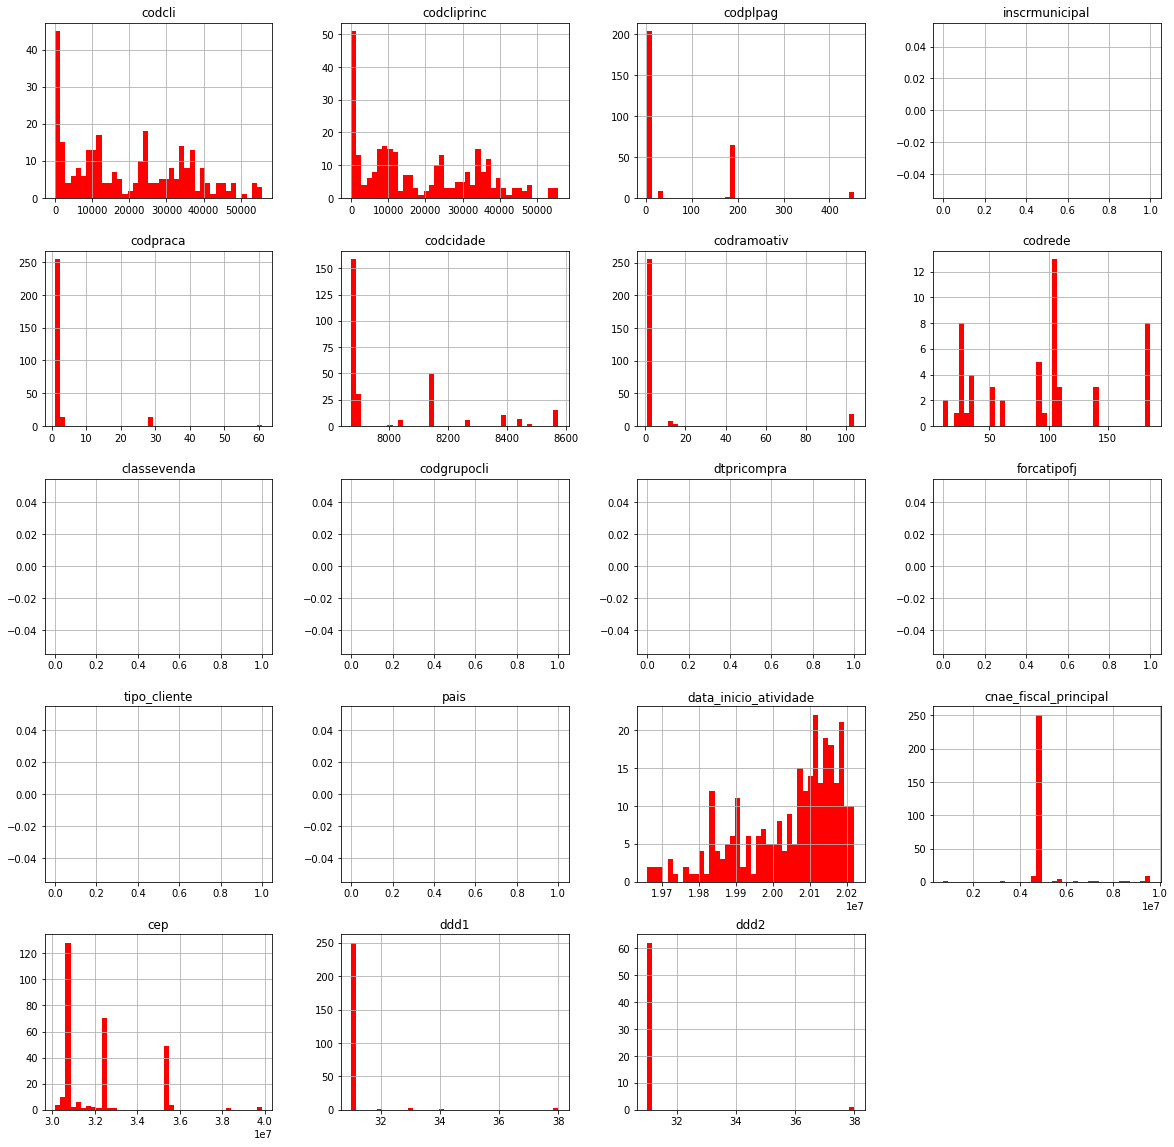

In [ ]:
cli_gama_cnae.hist(bins = 40, figsize=(20,20), color = 'r');

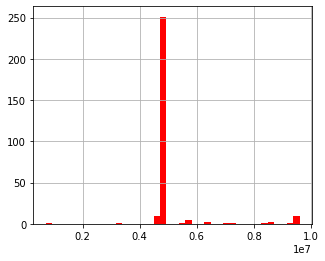

In [ ]:
cli_gama_cnae.cnae_fiscal_principal.hist(bins = 40, figsize=(5,4), color = 'r');

In [ ]:
cli_gama_cnae.cnae_fiscal_principal.value_counts()

4771701.0    198
4772500.0     13
4712100.0     10
4771702.0      7
5611203.0      3
9602502.0      3
4761003.0      3
9602501.0      3
4729699.0      2
4789003.0      2
4645101.0      2
4763601.0      2
9430800.0      2
4773300.0      2
4711302.0      2
4781400.0      2
7112000.0      1
6463800.0      1
4642702.0      1
6319400.0      1
4789005.0      1
7319002.0      1
4663000.0      1
4721102.0      1
5811500.0      1
4744099.0      1
4761001.0      1
4741500.0      1
9420100.0      1
5590699.0      1
4789099.0      1
3250701.0      1
8550301.0      1
4789004.0      1
8411600.0      1
4520002.0      1
5620103.0      1
710301.0       1
9313100.0      1
8630504.0      1
4755502.0      1
4619200.0      1
4724500.0      1
4644301.0      1
4930201.0      1
Name: cnae_fiscal_principal, dtype: int64

In [ ]:
cnaes[cnaes['cnae'] == 4771701]

,cnae,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
872,4771701,"Comércio varejista de produtos farmacêuticos, ...",G,47,47.7,47.71-7,4771-7/01,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO VAREJISTA,"Comércio varejista de produtos farmacêuticos, ...",Comércio varejista de produtos farmacêuticos p...,"Comércio varejista de produtos farmacêuticos, ..."


In [ ]:
cnaes[cnaes['cnae'] == 4772500]

,cnae,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
876,4772500,"Comércio varejista de cosméticos, produtos de ...",G,47,47.7,47.72-5,4772-5/00,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO VAREJISTA,"Comércio varejista de produtos farmacêuticos, ...","Comércio varejista de cosméticos, produtos de ...","Comércio varejista de cosméticos, produtos de ..."


In [ ]:
cnaes[cnaes['cnae'] == 4712100]

,cnae,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
819,4712100,"Comércio varejista de mercadorias em geral, co...",G,47,47.1,47.12-1,4712-1/00,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO VAREJISTA,Comércio varejista não especializado,"Comércio varejista de mercadorias em geral, co...","Comércio varejista de mercadorias em geral, co..."


## Criando um dataset

- Target 1 para todos os clientes do vendedor do dataset 'cli_gama_cnae'

- Target 0 para aqueles que não tem uma das divisões do CNAE do target 1

### **Features:**

- Capital social (merge com a tabela de mepresas);
- Porte (merge com a tabela de mepresas);
- Nº de CNAEs secundários (contar quantos secundarios tem na base de CNPJ);
- CNAE separado por: Seção, Divisão, Grupo, Classe e Subclasse;
- CNAEs secundários separados por: Seção, Divisão, Grupo, Classe e Subclasse (limitado a 5 CNAEs);
- Idade da empresa (usar a feature 'data_inicio_atividade').

In [ ]:
df.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674957 entries, 0 to 1674956
Data columns (total 17 columns):
 #   Column                       Non-Null Count    Dtype 
---  ------                       --------------    ----- 
 0   cnpj                         1674957 non-null  object
 1   cnpj_basico                  1674957 non-null  object
 2   identificador_matriz_filial  1674957 non-null  object
 3   data_inicio_atividade        1674957 non-null  object
 4   cnae                         1674957 non-null  object
 5   cnae_fiscal_principal        1674957 non-null  object
 6   cnae_fiscal_secundaria       716685 non-null   object
 7   tipo_logradouro              1654049 non-null  object
 8   logradouro                   1674944 non-null  object
 9   numero                       1674953 non-null  object
 10  complemento                  704977 non-null   object
 11  bairro                       1666614 non-null  object
 12  cep                          1674955 non-null  object
 1

In [ ]:
df.shape

(1674957, 17)

In [ ]:
df_todos.shape

(28207, 17)

Juntando os dados docliente com o estado, pois nem todos os clientes são desse estado em específico

In [ ]:
dfj = pd.merge(df, df_todos, how = 'outer', on = 'cnpj')
dfj['cnpj'].is_unique

True

In [ ]:
dfj.shape

(1686235, 33)

In [ ]:
cnaes.head()

In [ ]:
df_merge = pd.merge(df, cnaes, how = 'left', on = 'cnae')
df_merge.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,82.3,82.30-0,8230-0/01,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,..."
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,43.9,43.99-1,4399-1/03,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,45.2,45.20-0,4520-0/02,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,96.0,96.02-5,9602-5/01,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure"
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,77.3,77.39-0,7739-0/02,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e..."


In [ ]:
df_merge.shape

(1674957, 28)

In [ ]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674957 entries, 0 to 1674956
Data columns (total 28 columns):
 #   Column                       Non-Null Count    Dtype 
---  ------                       --------------    ----- 
 0   cnpj                         1674957 non-null  object
 1   cnpj_basico                  1674957 non-null  object
 2   identificador_matriz_filial  1674957 non-null  object
 3   data_inicio_atividade        1674957 non-null  object
 4   cnae                         1674957 non-null  object
 5   cnae_fiscal_principal        1674957 non-null  object
 6   cnae_fiscal_secundaria       716685 non-null   object
 7   tipo_logradouro              1654049 non-null  object
 8   logradouro                   1674944 non-null  object
 9   numero                       1674953 non-null  object
 10  complemento                  704977 non-null   object
 11  bairro                       1666614 non-null  object
 12  cep                          1674955 non-null  object
 1

In [ ]:
df_merge['Grupo'] = df_merge['Grupo'].str.replace('.','')
df_merge['Classe'] = df_merge['Classe'].str.replace('.','')
df_merge['Classe'] = df_merge['Classe'].str.replace('-','')
df_merge['Subclasse'] = df_merge['Subclasse'].str.replace('-','')
df_merge['Subclasse'] = df_merge['Subclasse'].str.replace('/','')

df_merge.head()

<ipython-input-7-1398a87c438c>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_merge['Grupo'] = df_merge['Grupo'].str.replace('.','')
<ipython-input-7-1398a87c438c>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_merge['Classe'] = df_merge['Classe'].str.replace('.','')


,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,..."
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure"
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e..."


In [ ]:
from datetime import datetime

now = datetime.now()
df_merge['idade_empresa'] = df_merge['data_inicio_atividade'].astype(str).apply(lambda x: (now - datetime.strptime(x, '%Y%m%d')).days)

df_merge.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210


In [ ]:
df_merge['idade_empresa'].value_counts()

In [ ]:
df_merge.isnull().sum()

cnpj                                 0
cnpj_basico                          0
identificador_matriz_filial          0
data_inicio_atividade                0
cnae                                 0
cnae_fiscal_principal                0
cnae_fiscal_secundaria         3538072
tipo_logradouro                  52805
logradouro                          39
numero                              39
complemento                    3812630
bairro                           61789
cep                                  0
uf                                   0
municipio                            0
capital_social                       0
porte                                1
Denominação                          0
Seção                               70
Divisão                              0
Grupo                           220948
Classe                          220948
Subclasse                            0
Seção_str                           70
Divisão_str                          0
Grupo_str                

In [ ]:
df_merge.shape

(6017111, 29)

In [ ]:
df_merge.to_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/df_merge.csv', index=False)

## CNAE secundário

In [ ]:
df_merge=pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/df_merge.csv')
df_merge.head()

In [ ]:
df_merge.shape

In [ ]:
lista_cnae = []
for cnae_sec in df_merge['cnae_fiscal_secundaria']:
  lista_cnae.append(str(cnae_sec).split(','))
lista_cnae

[['nan'],
 ['4321500', '4330404'],
 ['4520005', '4399103', '4330404', '4330405'],
 ['nan'],
 ['nan'],
 ['5912099', '1821100'],
 ['4789099',
  '4789001',
  '4755502',
  '4763602',
  '4755503',
  '4763601',
  '4782201',
  '4783102',
  '4783101'],
 ['nan'],
 ['4321500', '1091102'],
 ['nan'],
 ['nan'],
 ['1091101'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['5620104', '5620101', '8292000'],
 ['nan'],
 ['4781400'],
 ['5212500', '4930202'],
 ['4541206', '4541207', '4530704'],
 ['nan'],
 ['7420004',
  '9001906',
  '5812302',
  '5812301',
  '9001902',
  '5912001',
  '9609299',
  '7420001'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['4789003',
  '1412602',
  '4789001',
  '1412601',
  '1091102',
  '1749400',
  '1813099',
  '1095300',
  '1359600',
  '4755501',
  '5620104',
  '4763601',
  '1732000',
  '1340599'],
 ['4930201'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['nan'],
 ['4634602'],
 ['nan'],
 ['4930201', '4929901'],
 ['nan'],
 ['nan'],
 ['8599604'],
 ['nan'],
 ['4120400

In [ ]:
len(lista_cnae)

6017111

In [ ]:
lista_cnae[2][0]

'4520005'

In [ ]:
range(len(lista_cnae)-1)

range(0, 6017110)

In [ ]:
CNAE_secundario_1 = []
CNAE_secundario_2 = []
CNAE_secundario_3 = []
CNAE_secundario_4 = []
CNAE_secundario_5 = []

for indice1 in range(len(lista_cnae)):
    CNAE_secundario_1.append(lista_cnae[indice1][0])
    
    if len(lista_cnae[indice1]) >= 2:
      CNAE_secundario_2.append(lista_cnae[indice1][1])
    else:
      CNAE_secundario_2.append('nan')

    if len(lista_cnae[indice1]) >= 3:
      CNAE_secundario_3.append(lista_cnae[indice1][2])
    else:
      CNAE_secundario_3.append('nan')

    if len(lista_cnae[indice1]) >= 4:
      CNAE_secundario_4.append(lista_cnae[indice1][3])
    else:
      CNAE_secundario_4.append('nan')

    if len(lista_cnae[indice1]) >= 5:
      CNAE_secundario_5.append(lista_cnae[indice1][4])
    else:
      CNAE_secundario_5.append('nan')

df_merge.insert(29,"cnae_sec_1", CNAE_secundario_1, True)
df_merge.insert(30,"cnae_sec_2", CNAE_secundario_2, True)
df_merge.insert(31,"cnae_sec_3", CNAE_secundario_3, True)
df_merge.insert(32,"cnae_sec_4", CNAE_secundario_4, True)
df_merge.insert(33,"cnae_sec_5", CNAE_secundario_5, True)

df_merge.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,nan,nan,nan,nan,nan
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,nan,nan,nan
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,nan
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,nan,nan,nan,nan,nan
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,nan,nan,nan,nan,nan


In [ ]:
df_merge.to_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/df_merge.csv', index=False)

### Separando o CNAE secundário por partes

In [ ]:
df_merge=pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/df_merge.csv', dtype=str)
df_merge.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN


In [ ]:
cnaes_col = cnaes.loc[:,['Seção',	'Divisão',	'Grupo',	'Classe',	'Subclasse']]
cnaes_col.head()

,Seção,Divisão,Grupo,Classe,Subclasse
0,A,01,01.1,01.11-3,0111-3/01
1,A,01,01.1,01.11-3,0111-3/02
2,A,01,01.1,01.11-3,0111-3/03
3,A,01,01.1,01.11-3,0111-3/99
4,A,01,01.1,01.12-1,0112-1/01


In [ ]:
cnaes_col['Grupo'] = cnaes_col['Grupo'].str.replace('.','')
cnaes_col['Classe'] = cnaes_col['Classe'].str.replace('.','')
cnaes_col['Classe'] = cnaes_col['Classe'].str.replace('-','')
cnaes_col['Subclasse'] = cnaes_col['Subclasse'].str.replace('-','')
cnaes_col['Subclasse'] = cnaes_col['Subclasse'].str.replace('/','')

<ipython-input-5-4c1ca82fc7aa>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cnaes_col['Grupo'] = cnaes_col['Grupo'].str.replace('.','')
<ipython-input-5-4c1ca82fc7aa>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cnaes_col['Classe'] = cnaes_col['Classe'].str.replace('.','')


In [ ]:
cnaes_col.head()

,Seção,Divisão,Grupo,Classe,Subclasse
0,A,01,011,01113,0111301
1,A,01,011,01113,0111302
2,A,01,011,01113,0111303
3,A,01,011,01113,0111399
4,A,01,011,01121,0112101


#### CNAE Secundário 1

In [ ]:
cnaes_col.rename(columns={'Seção': 'Seção1'}, inplace=True)
cnaes_col.rename(columns={'Divisão': 'Divisão1'}, inplace=True)
cnaes_col.rename(columns={'Grupo': 'Grupo1'}, inplace=True)
cnaes_col.rename(columns={'Classe': 'Classe1'}, inplace=True)
cnaes_col.rename(columns={'Subclasse': 'cnae_sec_1'}, inplace=True)

cnaes_col.head()

,Seção1,Divisão1,Grupo1,Classe1,cnae_sec_1
0,A,01,011,01113,0111301
1,A,01,011,01113,0111302
2,A,01,011,01113,0111303
3,A,01,011,01113,0111399
4,A,01,011,01121,0112101


In [ ]:
df_merge1 = pd.merge(df_merge, cnaes_col, how = 'left', on = 'cnae_sec_1')
df_merge1.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,Seção1,Divisão1,Grupo1,Classe1
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN,F,43,432,43215
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN,G,45,452,45200
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### CNAE Secundário 2

In [ ]:
cnaes_col.rename(columns={'Seção1': 'Seção2'}, inplace=True)
cnaes_col.rename(columns={'Divisão1': 'Divisão2'}, inplace=True)
cnaes_col.rename(columns={'Grupo1': 'Grupo2'}, inplace=True)
cnaes_col.rename(columns={'Classe1': 'Classe2'}, inplace=True)
cnaes_col.rename(columns={'cnae_sec_1': 'cnae_sec_2'}, inplace=True)

cnaes_col.head()

,Seção2,Divisão2,Grupo2,Classe2,cnae_sec_2
0,A,01,011,01113,0111301
1,A,01,011,01113,0111302
2,A,01,011,01113,0111303
3,A,01,011,01113,0111399
4,A,01,011,01121,0112101


In [ ]:
df_merge1 = pd.merge(df_merge1, cnaes_col, how = 'left', on = 'cnae_sec_2')
df_merge1.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,Seção1,Divisão1,Grupo1,Classe1,Seção2,Divisão2,Grupo2,Classe2
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN,F,43,432,43215,F,43,433,43304
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN,G,45,452,45200,F,43,439,43991
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### CNAE Secundário 3

In [ ]:
cnaes_col.rename(columns={'Seção2': 'Seção3'}, inplace=True)
cnaes_col.rename(columns={'Divisão2': 'Divisão3'}, inplace=True)
cnaes_col.rename(columns={'Grupo2': 'Grupo3'}, inplace=True)
cnaes_col.rename(columns={'Classe2': 'Classe3'}, inplace=True)
cnaes_col.rename(columns={'cnae_sec_2': 'cnae_sec_3'}, inplace=True)

cnaes_col.head()

,Seção3,Divisão3,Grupo3,Classe3,cnae_sec_3
0,A,01,011,01113,0111301
1,A,01,011,01113,0111302
2,A,01,011,01113,0111303
3,A,01,011,01113,0111399
4,A,01,011,01121,0112101


In [ ]:
df_merge1 = pd.merge(df_merge1, cnaes_col, how = 'left', on = 'cnae_sec_3')
df_merge1.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,Seção1,Divisão1,Grupo1,Classe1,Seção2,Divisão2,Grupo2,Classe2,Seção3,Divisão3,Grupo3,Classe3
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN,F,43,432,43215,F,43,433,43304,NaN,NaN,NaN,NaN
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN,G,45,452,45200,F,43,439,43991,F,43,433,43304
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merge1.to_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/df_merge1.csv', index=False)

#### CNAE Secundário 4

In [ ]:
df_merge1=pd.read_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/CNPJ_metadados/df_merge1.csv', dtype=str)
df_merge1.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,Seção1,Divisão1,Grupo1,Classe1,Seção2,Divisão2,Grupo2,Classe2,Seção3,Divisão3,Grupo3,Classe3
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN,F,43,432,43215,F,43,433,43304,NaN,NaN,NaN,NaN
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN,G,45,452,45200,F,43,439,43991,F,43,433,43304
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cnaes_col.rename(columns={'Seção3': 'Seção4'}, inplace=True)
cnaes_col.rename(columns={'Divisão3': 'Divisão4'}, inplace=True)
cnaes_col.rename(columns={'Grupo3': 'Grupo4'}, inplace=True)
cnaes_col.rename(columns={'Classe3': 'Classe4'}, inplace=True)
cnaes_col.rename(columns={'cnae_sec_3': 'cnae_sec_4'}, inplace=True)

cnaes_col.head()

,Seção4,Divisão4,Grupo4,Classe4,cnae_sec_4
0,A,01,011,01113,0111301
1,A,01,011,01113,0111302
2,A,01,011,01113,0111303
3,A,01,011,01113,0111399
4,A,01,011,01121,0112101


In [ ]:
df_merge1 = pd.merge(df_merge1, cnaes_col, how = 'left', on = 'cnae_sec_4')
df_merge1.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,Seção1,Divisão1,Grupo1,Classe1,Seção2,Divisão2,Grupo2,Classe2,Seção3,Divisão3,Grupo3,Classe3,Seção4,Divisão4,Grupo4,Classe4
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN,F,43,432,43215,F,43,433,43304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN,G,45,452,45200,F,43,439,43991,F,43,433,43304,F,43,433,43304
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### CNAE Secundário 5

In [ ]:
cnaes_col.rename(columns={'Seção4': 'Seção5'}, inplace=True)
cnaes_col.rename(columns={'Divisão4': 'Divisão5'}, inplace=True)
cnaes_col.rename(columns={'Grupo4': 'Grupo5'}, inplace=True)
cnaes_col.rename(columns={'Classe4': 'Classe5'}, inplace=True)
cnaes_col.rename(columns={'cnae_sec_4': 'cnae_sec_5'}, inplace=True)

cnaes_col.head()

,Seção5,Divisão5,Grupo5,Classe5,cnae_sec_5
0,A,01,011,01113,0111301
1,A,01,011,01113,0111302
2,A,01,011,01113,0111303
3,A,01,011,01113,0111399
4,A,01,011,01121,0112101


In [ ]:
df_merge1 = pd.merge(df_merge1, cnaes_col, how = 'left', on = 'cnae_sec_5')
df_merge1.head()

,cnpj,cnpj_basico,identificador_matriz_filial,data_inicio_atividade,cnae,cnae_fiscal_principal,cnae_fiscal_secundaria,tipo_logradouro,logradouro,numero,complemento,bairro,cep,uf,municipio,capital_social,porte,Denominação,Seção,Divisão,Grupo,Classe,Subclasse,Seção_str,Divisão_str,Grupo_str,Classe_str,Subclasse_str,idade_empresa,cnae_sec_1,cnae_sec_2,cnae_sec_3,cnae_sec_4,cnae_sec_5,Seção1,Divisão1,Grupo1,Classe1,Seção2,Divisão2,Grupo2,Classe2,Seção3,Divisão3,Grupo3,Classe3,Seção4,Divisão4,Grupo4,Classe4,Seção5,Divisão5,Grupo5,Classe5
0,35.464.865/0001-93,35464865,MATRIZ,20191109,8230001,"Serviços de organização de feiras, congressos,...",NaN,AREA,AVENIDA ISRAEL PINHEIRO,22,NaN,SANTA MARGARIDA,36913000,MG,SANTA MARGARIDA,300.0,01,"Serviços de organização de feiras, congressos,...",N,82,823,82300,8230001,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,"SERVIÇOS DE ESCRITÓRIO, DE APOIO ADMINISTRATIV...","Atividades de organização de eventos, exceto c...","Atividades de organização de eventos, exceto c...","Serviços de organização de feiras, congressos,...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.464.962/0001-86,35464962,MATRIZ,20191109,4399103,Obras de alvenaria,"4321500,4330404",RUA,BARBACENA,528,SALA 01,PENHA,37903074,MG,PASSOS,5000.0,01,Obras de alvenaria,F,43,439,43991,4399103,CONSTRUÇÃO,SERVIÇOS ESPECIALIZADOS PARA CONSTRUÇÃO,Outros serviços especializados para construção,Serviços especializados para construção não es...,Obras de alvenaria,1210,4321500,4330404,NaN,NaN,NaN,F,43,432,43215,F,43,433,43304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35.465.399/0001-60,35465399,MATRIZ,20191109,4520002,Serviços de lanternagem ou funilaria e pintura...,"4520005,4399103,4330404,4330405",10A RUA,OLEGARIO MACIEL,315,NaN,BELA VISTA,33400000,MG,LAGOA SANTA,5000.0,01,Serviços de lanternagem ou funilaria e pintura...,G,45,452,45200,4520002,COMÉRCIO; REPARAÇÃO DE VEÍCULOS AUTOMOTORES E ...,COMÉRCIO E REPARAÇÃO DE VEÍCULOS AUTOMOTORES E...,Manutenção e reparação de veículos automotores,Manutenção e reparação de veículos automotores,Serviços de lanternagem ou funilaria e pintura...,1210,4520005,4399103,4330404,4330405,NaN,G,45,452,45200,F,43,439,43991,F,43,433,43304,F,43,433,43304,NaN,NaN,NaN,NaN
3,35.465.446/0001-76,35465446,MATRIZ,20191109,9602501,"Cabeleireiros, manicure e pedicure",NaN,RUA,JOAO LUCIO,737,CASA,PROGRESSO,38178000,MG,PEDRINOPOLIS,1000.0,01,"Cabeleireiros, manicure e pedicure",S,96,960,96025,9602501,OUTRAS ATIVIDADES DE SERVIÇOS,OUTRAS ATIVIDADES DE SERVIÇOS PESSOAIS,Outras atividades de serviços pessoais,Cabeleireiros e outras atividades de tratament...,"Cabeleireiros, manicure e pedicure",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.465.492/0001-75,35465492,MATRIZ,20191109,7739002,"Aluguel de equipamentos científicos, médicos e...",NaN,RUA,JOSE DO PATROCINIO,255,APT 405,MUNDO NOVO,36026340,MG,JUIZ DE FORA,2000.0,01,"Aluguel de equipamentos científicos, médicos e...",N,77,773,77390,7739002,ATIVIDADES ADMINISTRATIVAS E SERVIÇOS COMPLEME...,ALUGUÉIS NÃO IMOBILIÁRIOS E GESTÃO DE ATIVOS I...,Aluguel de máquinas e equipamentos sem operador,Aluguel de máquinas e equipamentos não especif...,"Aluguel de equipamentos científicos, médicos e...",1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merge1.to_csv('/content/drive/MyDrive/Projetos_ion/ION_Prospeccao_Inteligente/datasets/Farmix/dataset_mg_farmix.csv', index=False)